/home/livablecity/miniconda3/envs/temp_env/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/home/livablecity/miniconda3/envs/temp_env/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/tmp/ipykernel_4889/3566055271.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volume = all_data.resample("M").mean()


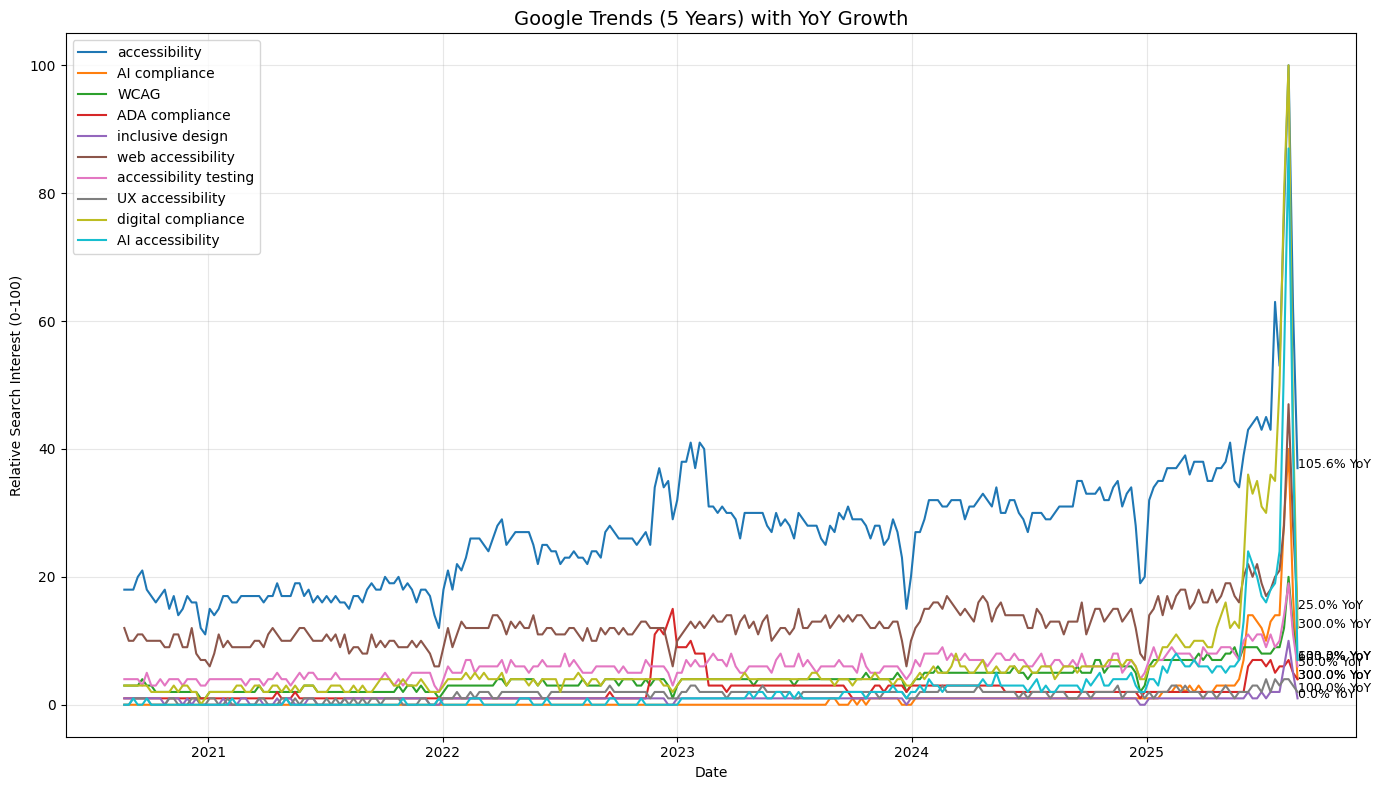

✅ 趋势数据、YoY 增长率、月度数据已导出为 CSV


In [1]:
# pip install pytrends matplotlib pandas

from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt

# 初始化 pytrends
pytrends = TrendReq(hl='en-US', tz=360)

# 你的关键词列表（<= 5 个一组，可以循环分组）
keywords = ["accessibility", "AI compliance", "WCAG", "ADA compliance", "inclusive design",
            "web accessibility", "accessibility testing", "UX accessibility", "digital compliance", "AI accessibility"]

# 存储所有结果
all_data = pd.DataFrame()

# 循环分组，每次最多 5 个关键词
for i in range(0, len(keywords), 5):
    kw_group = keywords[i:i+5]
    pytrends.build_payload(kw_group, timeframe='today 5-y', geo='', gprop='')
    df = pytrends.interest_over_time()
    df = df.drop(columns=['isPartial'])
    all_data = pd.concat([all_data, df], axis=1)

# 去重（pytrends 有时重复）
all_data = all_data.loc[:, ~all_data.columns.duplicated()]
all_data.index = pd.to_datetime(all_data.index)

# ---- 计算 YoY 增长率 ----
def yoy_growth(series):
    # 从第一个非零值开始
    first_non_zero = series[series > 0].first_valid_index()
    if first_non_zero is None:
        return pd.Series([None]*len(series), index=series.index)
    base = series[first_non_zero]
    return (series - base) / base * 100

yoy_data = all_data.apply(yoy_growth)

# ---- 计算 Monthly global search volume (Trends 数据本质上是相对指数) ----
# 这里我们展示的是平均值，而不是绝对搜索量
monthly_volume = all_data.resample("M").mean()

# ---- 绘图 ----
plt.figure(figsize=(14, 8))

for col in all_data.columns:
    plt.plot(all_data.index, all_data[col], label=f"{col}")

    # 标注最后一个点的 YoY 增长率
    last_val = all_data[col].iloc[-1]
    last_yoy = yoy_data[col].iloc[-1]
    plt.text(all_data.index[-1], last_val, f"{last_yoy:.1f}% YoY", fontsize=9)

plt.title("Google Trends (5 Years) with YoY Growth", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Relative Search Interest (0-100)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---- 保存数据 ----
all_data.to_csv("trends_raw.csv")
yoy_data.to_csv("trends_yoy.csv")
monthly_volume.to_csv("trends_monthly.csv")

print("✅ 趋势数据、YoY 增长率、月度数据已导出为 CSV")


In [ ]:
from pytrends.request import TrendReq
import pandas as pd

def get_monthly_trends_with_yoy(keywords, geo="worldwide"):
    """
    获取关键词的 Google Trends 近5年趋势 (按月) + YoY 增长率

    Args:
        keywords (list[str]): 关键词列表
        geo (str): 地区代码，默认 worldwide。可用 "US", "CN" 等
    
    Returns:
        dict: 每个关键词对应的趋势数据和YoY结果
              {
                "trend": 原始月度时间序列 (pd.DataFrame),
                "yearly_avg": 年均值 (pd.DataFrame),
                "yoy_growth": YoY 增长率 (pd.DataFrame)
              }
    """
    pytrends = TrendReq(hl='en-US', tz=360,timeout=(10, 30))
    results = {}

    for kw in keywords:
        # 获取近5年趋势 (Google Trends 默认周频率)
        pytrends.build_payload([kw], timeframe='today 5-y', geo='', gprop='')
        df = pytrends.interest_over_time()

        if df.empty:
            print(f"⚠️ No data for {kw}")
            continue

        df = df.drop(columns=["isPartial"])
        df = df.infer_objects(copy=False)  # 避免 future downcasting warning

        # 转换为月度频率 (ME = MonthEnd)
        df_monthly = df.resample("ME").mean()

        # 按年份计算年均值 (YE = YearEnd)
        yearly = df_monthly.resample("YE").mean()
        yearly.index = yearly.index.year

        # 过滤掉全零年份
        yearly = yearly[yearly[kw] > 0]

        # 计算YoY 增长率
        yoy = yearly.pct_change().dropna() * 100

        results[kw] = {
            "trend": df_monthly,   # 原始月度时间序列
            "yoy_growth": yoy      # YoY 增长率 (%)
        }
    
    return results


In [ ]:
keywords = ["AI SaaS", "cloud computing", "web3"]
results = get_monthly_trends_with_yoy(keywords)

# 查看某个关键词的月度趋势曲线
print(results["AI SaaS"]["trend"])

# 查看年均值
print(results["AI SaaS"]["yearly_avg"])

# 查看YoY 增长率
print(results["AI SaaS"]["yoy_growth"])


/home/livablecity/miniconda3/envs/temp_env/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/home/livablecity/miniconda3/envs/temp_env/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


            AI SaaS
date               
2020-08-31     0.50
2020-09-30     0.50
2020-10-31     0.50
2020-11-30     0.20
2020-12-31     0.25
        AI SaaS
date           
2020   0.390000
2021   0.504167
2022   1.079167
2023   3.079167
2024   5.279167
2025  22.687500
         AI SaaS
date            
2021   29.273504
2022  114.049587
2023  185.328185
2024   71.447903
2025  329.755328


/home/livablecity/miniconda3/envs/temp_env/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


In [7]:
print(results["AI SaaS"]["trend"])

            AI SaaS
date               
2020-08-31     0.50
2020-09-30     0.50
2020-10-31     0.50
2020-11-30     0.20
2020-12-31     0.25
...             ...
2025-04-30     9.25
2025-05-31    11.25
2025-06-30    36.60
2025-07-31    37.00
2025-08-31    60.50

[61 rows x 1 columns]
